# Introduction to model fitting

### Goals:

1. To understand what it means to fit a model, and to derive estimates for the values on the parameters in the model.
2. To fit a linear model for the time variation of the flux of the Vela pulsar to the data.
3. To use the results of that fit to decide if the flux of the Vela pulsar is, in fact, varying with time.

### Timing

1. Try to finish this notebook in 35-45 minutes. 


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import scipy.optimize as optimize
import datetime

plt.rcParams['font.size'] = 14

### New functions we will use in this module

| Function Name            | What it does |
| - | - |
|  plt.contour |  Make a contour plot, ie., show the contours correspond to a series of values |
| scipy.stats.chi2 | Interact with a $\chi^2$ distribution, e.g., to compute a p-value |

### This figure summarizes the essence of this notebook:

<img src="figures/Fitting.png" alt="drawing" width="40%"/>

### Ok, let's pick up where we left off with the Vela pulsar data!

(This cell is just a repeat of loading the Vela data)

In [2]:
data = np.loadtxt(open("../data/Vela_Flux.txt", 'rb'), usecols=range(7))

## This is how we pull out the data from columns in the array.

## This is the date in "Mission Elapsed Time" For the Fermi mission, this 
## is defined to be the number of seconds since the start of 2001.
date_MET = data[:,0]

## This is the offset in seconds between the Fermi "MET" and the UNIX 
## "epoch" used by matplotlib
MET_To_Unix = 978336000

## These are the number of photons observed from Vela each week in 
## the "low" Energy Band (100 MeV - 800 MeV)
nObs_LE = data[:,1]

## These are the number of photons expected from Vela each week, under 
## the assumption that it is not varying at all, and the only differences 
## depend on how long we spent looking at Vela that particular weeek
nExp_LE = data[:,2]

## These are the band bounds, in MeV
LE_bounds = (100., 800.)

## We will also take a look at data in the "high" energy band 
## (800 MeV - 10000 MeV)
nObs_HE = data[:,4]
nExp_HE = data[:,5]
signif_HE = data[:6]
HE_bounds = (800., 10000.)

## This converts the dates to something that matplotlib understands
dates = [datetime.datetime.fromtimestamp(date + MET_To_Unix) for date in date_MET]

## Convert the dates to years to make the numbers more sensible
date_YEAR = 2001 +  (date_MET / (24*3600*365))
years_since_mid_2014 = date_YEAR  - 2014.5

So, we are going to investigate if the small correlation between the excess and the time is statistically significant.   Let's start by looking at the data and adding uncertainties to the points and plotting it using the variables we just defined.

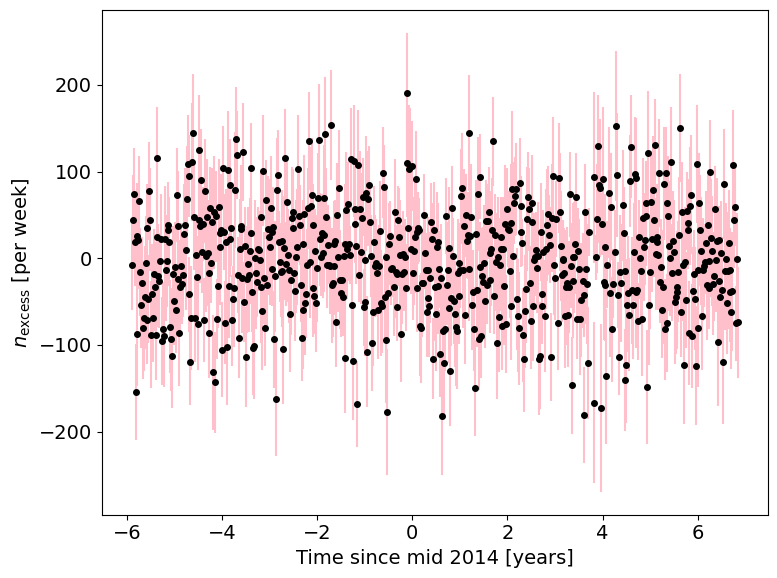

In [3]:
## Calculate the excess counts and estimate an uncertainty on the excess counts
## given by the square root of the observed counts, which assuming Poisson statistics
excess_counts = nObs_LE-nExp_LE
sigma_counts =  np.sqrt(nObs_LE)

## Plot the excess counts as a function of time, with some uncertainties
## and some custom plotting options to improve clarity
fig, ax = plt.subplots(figsize=(8, 6))

ax.errorbar(years_since_mid_2014, excess_counts, 
            fmt='ko', ms=4, ecolor='pink', yerr=sigma_counts)

ax.set_xlabel(r"Time since mid 2014 [years]")
ax.set_ylabel(r"$n_{\rm excess}$ [per week]")

fig.tight_layout()

plt.show()

# Step 1.   The model

We just write a simple function for our model, and plot how the model looks for a few values of the parameters. Call $p_0$ and $p_1$ our parameters, representing the offset and slope in a linear model, respectively. Then our model for time dependence, given these parameters, is:

$n_{\rm excess}(t | p_0, p_1) = p_0 + t * p_1$ 

In the next cell we will define a function that returns the model prediction for the y-values (i.e., excess counts) if you pass in a set of x-values (i.e., times).

In [4]:
def linear_function(xvals, params):
    return params[0] + xvals*params[1]

Now we are going to plot that model for a few different sets of paramters.

First we will change $p_0$, the offset parameter, and plot that.

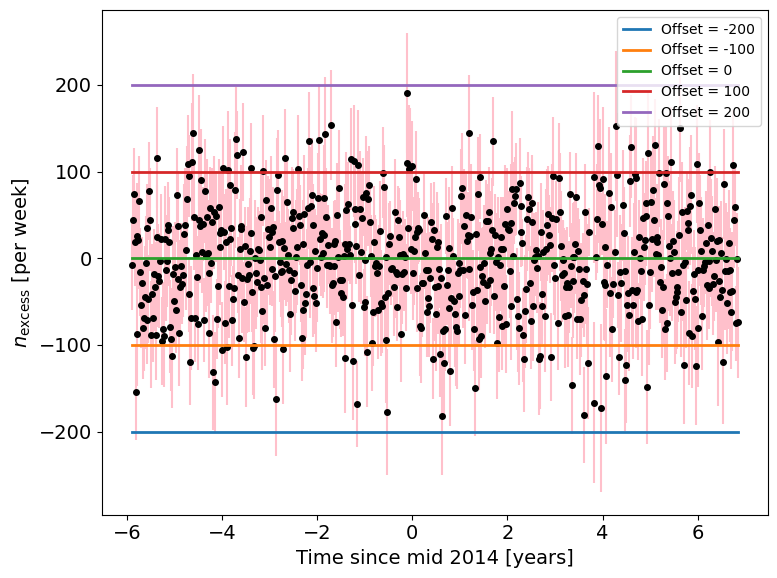

In [5]:
## Start by making the same plot as before with our excess counts and 
## associated uncertainties
fig, ax = plt.subplots(figsize=(8, 6))

ax.errorbar(years_since_mid_2014, excess_counts, 
            fmt='ko', ms=4, ecolor='pink', yerr=sigma_counts)

ax.set_xlabel(r"Time since mid 2014 [years]")
ax.set_ylabel(r"$n_{\rm excess}$ [per week]")

## Plot the linear model for a few different values of the constant offset
## i.e. parameter p0, i.e. params[0], all with a slope of zero
xvals = years_since_mid_2014
params = np.array([0, 0])
for offset in np.linspace(-200, 200, 5):
    params[0] = offset
    ax.plot(xvals, linear_function(xvals, params), lw=2, 
            label=rf"Offset = {offset:0.0f}", zorder=5)

ax.legend(fontsize=10)

fig.tight_layout()

plt.show()

Now we will change $p_1$, the slope, and plot that.

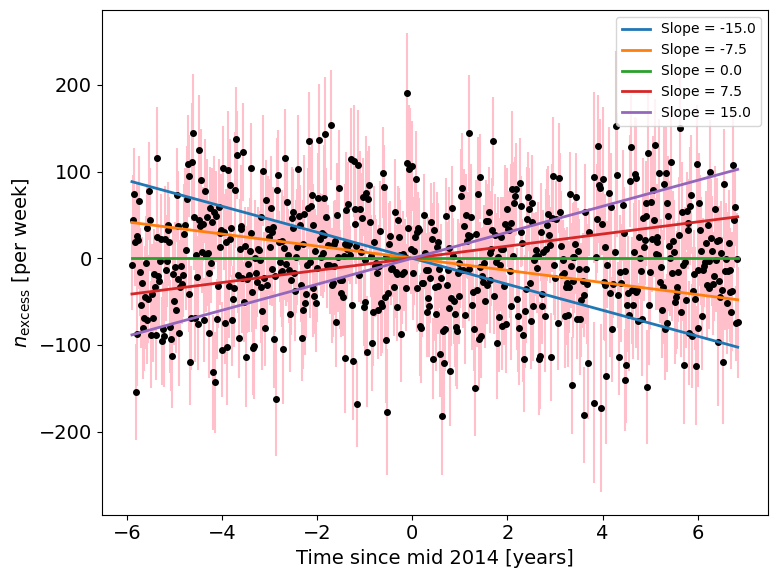

In [6]:
## Start by making the same plot as before with our excess counts and 
## associated uncertainties
fig, ax = plt.subplots(figsize=(8, 6))

ax.errorbar(years_since_mid_2014, excess_counts, 
            fmt='ko', ms=4, ecolor='pink', yerr=sigma_counts)

ax.set_xlabel(r"Time since mid 2014 [years]")
ax.set_ylabel(r"$n_{\rm excess}$ [per week]")

## Plot the linear model for a few different values of the slope parameter
## i.e. parameter p1, i.e. params[1], all with a constant offset of 0
xvals = years_since_mid_2014
params = np.array([0, 0])
for slope in np.linspace(-15, 15, 5):
    params[1] = slope
    ax.plot(xvals, linear_function(xvals, params), lw=2,
            label=rf"Slope = {slope:0.1f}", zorder=5)

ax.legend(fontsize=10)

fig.tight_layout()

plt.show()

### An important distinction:

When we refer to "the model", we are referring to the function which states that the number of counts changes linearly with time. A particular *version* of the model is one with a specific set of parameters.  

Keep that in mind as you answer the next question, and for the rest of the notebook.

### Questions for discussion

#### 4.1  How well do you think this model describes the data?  Is this a sensible model?   What would it mean if $p_0$ were very different from 0?  What about if $p_1$ were different from zero?

# Step 2.   The residuals

Let's try to quantify the agreement of the model with the data.

Let's write a function to plot the **residuals** given the model parameters.  

Let's define the residuals as: $\delta_i = n_{\rm ex,i} - m_{\rm ex,i} = n_{\rm ex,i} - (p_0  + t * p_1)$, or in words, the difference between the model predictions and the measured data points.

The first function `residual_function` computes the residuals $\delta_i$ for each week.  

The second function `plot_residuals` makes scatter plots of the residuals for different sets of model parameters versus time.

The third function `hist_residuals` makes histograms of the residuals for different sets of model parameters over all the weeks. 

Let's test these functions on two sets of model parameters: one where $(p_0,p_1) = (0,0)$, and one where $(p_0,p_1) = (0,20)$.

In [7]:
## Define a function that calculates the residuals between the data and the model,
## where the 'model' argument is itself a function of the form: model(xvals, params)
def residual_function(data_x, data_y, model_function, params):
    model_y = model_function(data_x, params)
    residual = data_y - model_y
    return residual

In [8]:
## Define a function to plot residuals for multiple arrays of the dependent
## variable, given a single array of the independent variable
def plot_residuals(xvals, yvals_list, ylabel=r'$\delta$ [counts]'):

    fig, ax = plt.subplots(figsize=(8, 6))

    ax.set_xlabel(r"Time since mid 2014 [years]")
    ax.set_ylabel(ylabel)
    for yvals in yvals_list:
        ax.scatter(xvals, yvals)

    fig.tight_layout()

    plt.show()

In [9]:
## The same type of function as above, but now for histograms of the residuals,
## with an optional argument to specify the binning. The optional argument is
## given a default value approriate for a standard normal distribution.
def hist_residuals(yvals_list, bins=np.linspace(-6, 6, 61), \
                   xlabel=r'$\delta$ [counts]', ylabel='# of weeks'):

    fig, ax = plt.subplots(figsize=(8, 6))

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    for yvals in yvals_list:
        ## Use the 'step' type to make a histogram with only the outlines
        ## so we can visualize multiple histograms on the same plot
        ax.hist(yvals, bins=bins, histtype='step', lw=2)

    fig.tight_layout()

    plt.show()

Now we'll take a look at the residuals for 2 sets of parameters, both with $p_0 = 0$: and one with $p_1 = 0$, and one with $p_1 = 20$.

In [10]:
resid_0_0  = residual_function(years_since_mid_2014, excess_counts, linear_function, [0,0])
resid_0_20 = residual_function(years_since_mid_2014, excess_counts, linear_function, [0,20])

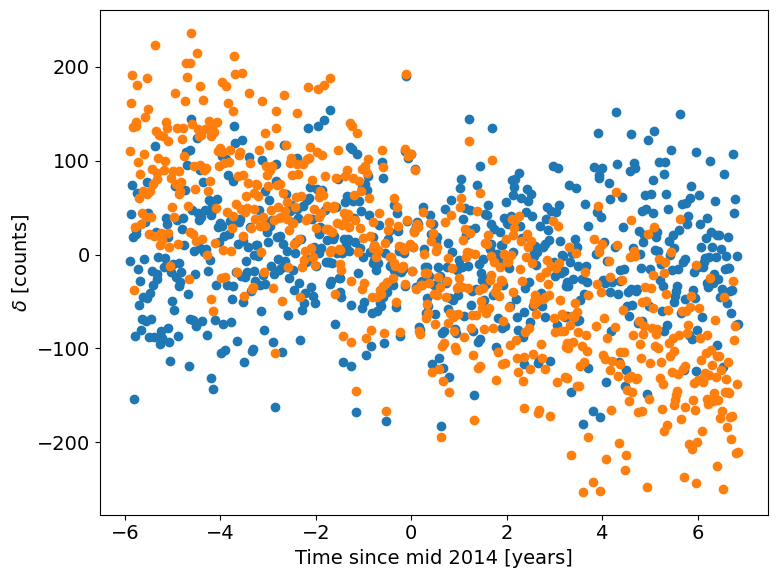

In [11]:
## Note that the first set of residuals plotted will be blue, and the second set will be orange
plot_residuals(years_since_mid_2014, [resid_0_0, resid_0_20])

### Quick question

##### Do the residuals match what you would expect? Remember that we've defined the residuals as: (resid) = (data) - (model)

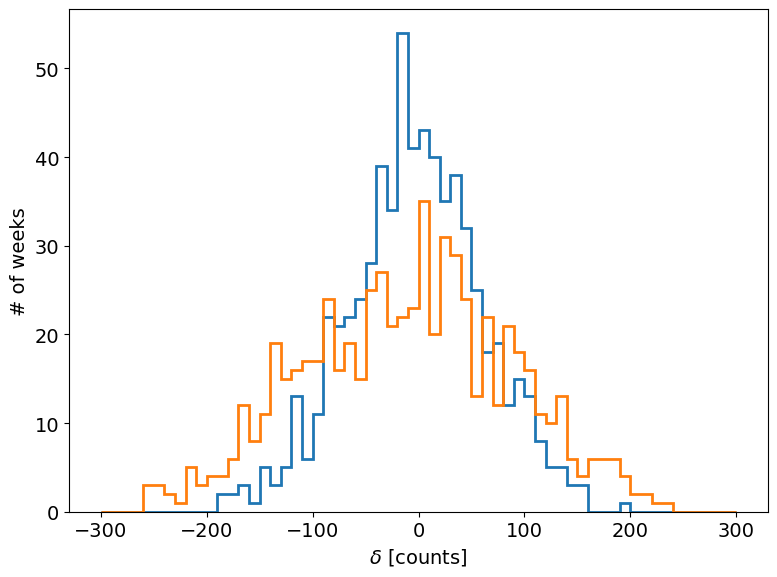

In [12]:
## Plot a histogram of the residuals, specifying the binning based on the
## range of the residuals observed above.
hist_residuals([resid_0_0, resid_0_20], bins=np.linspace(-300, 300, 61))

# Step 3.   The scaled residuals

We see there's some scatter to the residuals. However, we also know from previous notebooks that the data itself has an inherent spread, which we want to take into account when trying to assess the agreement between a model and data.

Let's write a function to plot the **scaled residuals** (i.e.,  the residuals divided by the uncertainties on the data points to scale them down to a unit Gaussian), given the model parameters:

$$\chi_i =  \frac{n_{\rm ex,i} - m_{\rm ex,i}}{\sigma_{obs, i}} = \frac{n_{\rm ex,i} - (p_0  + t_i * p_1)}{\sigma_{obs, i}}$$

Note that these residuals are now dimensionless! This allows us to make some general assessments about the statistical fluctuations in the data and compare them to normalized distributions

#### Here we scale the individual residuals, so that we can make nice scatter plots of the scaled residuals.

In [13]:
## Scale each array of residuals by the uncertainty on the counts for that particular observation
chi_0_0 = resid_0_0 / sigma_counts
chi_0_20 = resid_0_20 / sigma_counts

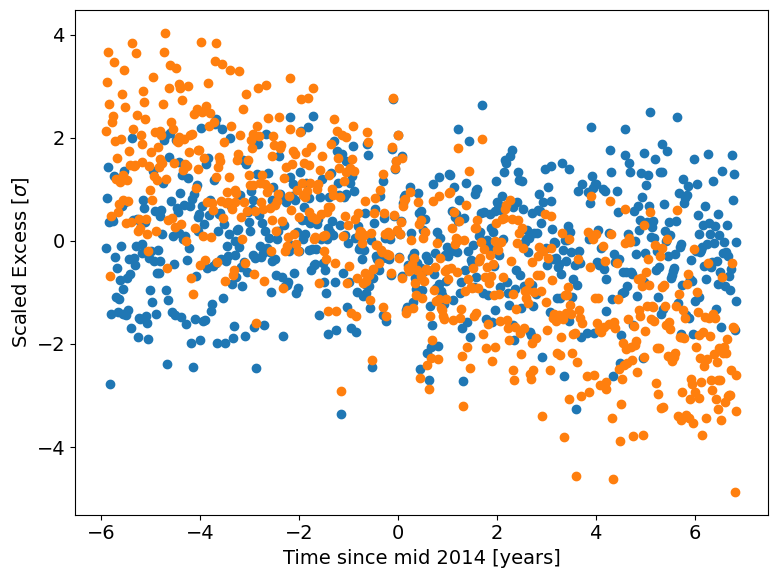

In [14]:
## Plot these new scaled residuals.
plot_residuals(years_since_mid_2014, [chi_0_0, chi_0_20], \
               ylabel=r'Scaled Excess [$\sigma$]')

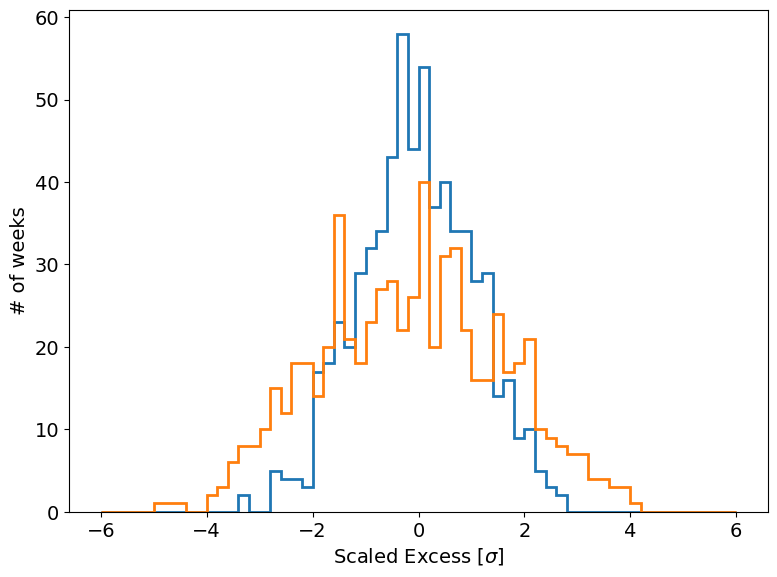

In [15]:
## We can plot these residuals without specifiying the binning, since the
## default binning is appropriate for a standard normal distribution and 
## we're working with scaled residuals.
hist_residuals([chi_0_0, chi_0_20], xlabel=r'Scaled Excess [$\sigma$]')

###  Questions for discussion.

#### 5.1 Using what we learned last week about Gaussian distributions and p-values, explain why the two plots with the scaled residuals are much more useful than the two plots with the unscaled residuals.

#### 5.2 Given the plot above, do you think that there is any chance that the true value of $p_1$ is actually 20 counts / year?  Explain why or why not.

# Step 4.   The $\chi^2$ distribution

Let's formulate a single number to summarize these residuals. Let's define: 

$$f(\chi_i) = \sum_i \chi_i^2,$$

where $\chi_i$ is the scaled residual for data point $i$.

The expected distribution of $f(\chi_i)$ is known, assuming $\chi_i$ follows a normal distribution centered at zero with $\sigma$ = 1. It should follow what is known as a $\chi^2$ distribution (given by the `scipy.stats.chi2` function). 

What types of numbers are described by the $\chi^2$ distribution? 

If we draw values $X_i$ from a normal distribution centered at zero with $\sigma$ = 1, then the sum of the squares of $X_i$ will follow a $\chi^2$ distribution. The form of this distribution has only one parameter, which we call the "degrees of freedom" (also called $DOF$ or $d_{f}$ in shorthand). The mean of the $\chi^2$ distribution is $d_f$, and the variance is $2d_f$.

Let's explore the distribution a little bit before going further with the Vela pulsar data.

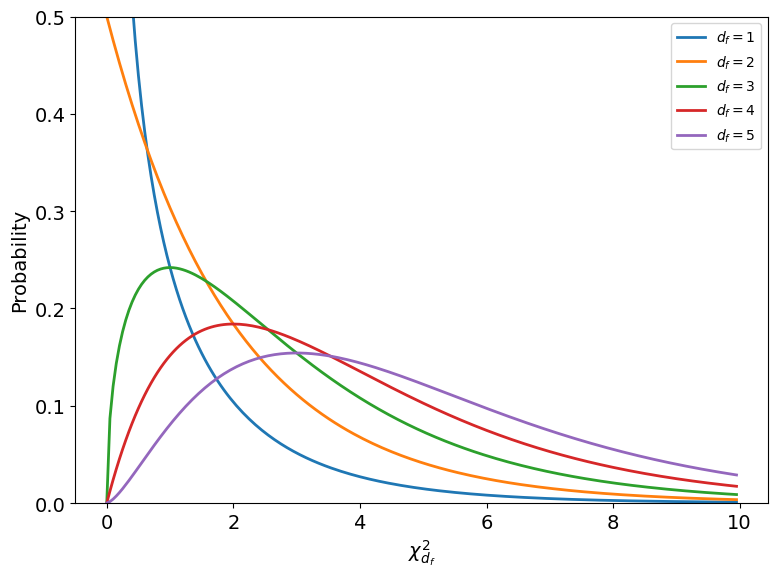

In [16]:
fig, ax = plt.subplots(figsize=(8, 6))

## Loop over different values of the degrees of freedom and plot the
## associated chi^2 distribution
x = np.arange(0,10,.05)
for df in [1,2,3,4,5]:
    ax.plot(x, stats.chi2(df=df).pdf(x), lw=2, label=rf"$d_f = {df:d}$")

ax.set_xlabel('$\chi_{d_f}^2$')
ax.set_ylabel('Probability')

ax.set_ylim(0,0.5)

ax.legend(fontsize=10)

fig.tight_layout()

plt.show()

In our case, the $\chi^2$ distribution applies because we are summing the squares of the scaled residuals.

As suggested by the name, "degrees of freedom" refers to the number of *independent* pieces of information we use when comparing observations to a model. In our case, this means the number of data points we have collected, minus the number of parameters in our model. So for our quantity $\chi^2$, the degrees of freedom are:

$d_f = n - m,$

where $n$ is the number of data points and $m$ is the number of fit parameters (so in our case, 2 for $p_0$ and $p_1$).

$f(\chi_i)$ is usually just referred to as $\chi^2$, or "chi-squared", because it follows the $\chi^2$ distribution. That's how we'll refer to it from now on. Since the mean of the $\chi^2$ distribution is $d_f$, for a "good" fit, $\chi^2/d_f$ should be approximately 1. 

Let's calculate some values of $\chi^2$ for our data and two sets of model parameters.

In [17]:
def chi2_function(data_x, data_y, data_sigma_y, model_function, params):
    model_y = model_function(data_x, params)
    chi2 = ((data_y - model_y)/(data_sigma_y))**2
    return np.sum(chi2)

In [18]:
chi2_0_0 = chi2_function(years_since_mid_2014, excess_counts, sigma_counts, linear_function, [0,0])
chi2_0_20 = chi2_function(years_since_mid_2014, excess_counts, sigma_counts, linear_function, [0,20])

## Manually compute the value of chi^2 for the first model, which 
## is the same as the sum of the squares of the scaled residuals. 
## We do this to check that our function definition is working.
chi2_check = np.sum(chi_0_0*chi_0_0)

## Compute the degrees of freedom from the size of the data and
## the known number of parameters
DOF = chi_0_0.size - 2

print(f"    Chi-squared(0,0)  : {chi2_0_0:0.1f}")
print(f"    Chi-squared check : {chi2_check:0.1f}")
print(f" Chi-squared(0,0)/DOF : {chi2_0_0/DOF:0.1f}\n")
print(f"    Chi-squared(0,20) : {chi2_0_20:0.1f}")
print(f"Chi-squared(0,20)/DOF : {chi2_0_20/DOF:0.1f}")

    Chi-squared(0,0)  : 765.2
    Chi-squared check : 765.2
 Chi-squared(0,0)/DOF : 1.2

    Chi-squared(0,20) : 1941.2
Chi-squared(0,20)/DOF : 3.0


Using the $\chi^2$ distribution, we can calculate the likelihood of observing a dataset with the given $\chi^2$ value if our model parameters are correct.

We'll use the same method as last week where we calculate a "survival fraction" by integrating the underlying distribution above the observed value of $\chi^2$, which yields something similar to a $p$-value.

In [19]:
print(f"The odds of seeing the observed data given params (0.,0.) are {stats.chi2(df=DOF).sf(chi2_0_0):.1e}")
print(f"The odds of seeing the observed data given params (0.,20.) are {stats.chi2(df=DOF).sf(chi2_0_20):.1e}")

The odds of seeing the observed data given params (0.,0.) are 1.1e-03
The odds of seeing the observed data given params (0.,20.) are 7.0e-129


### Question for discussion:

#### 6.1 We just saw that in an idealized case, the chance of seeing the observed data given model parameters (0, 20) is astonishingly less likely (by a factor of $10^{126}$) than the chance of seeing the observed data if the model parameters were (0, 0).  Explain why this is, using information from the plots above question 5.1 and 5.2.

# Step 5.  Minimizing the $\chi^2$

Now that we have a metric to quantify the difference between the model prediction and the data point, we can use this metric to find the values of $p_0,p_1$ which best describe the model. To do this, we can scan over parameter values and try to minimize the $\chi^2$ value. This effectively minimizes the residuals between the model and the data as a function of the model parameters.

# Scanning parameters.

We are first going to find the parameter values that minimize the $\chi^2$ by scanning each of the parameters and computing the resulting $\chi^2$. 

First we are going to scan each variable on its own.  Then we will do a two dimensional scan.

We will do $p_0$ (the offset parameter) first.  We will scan from -5 to 5 counts in 11 steps.

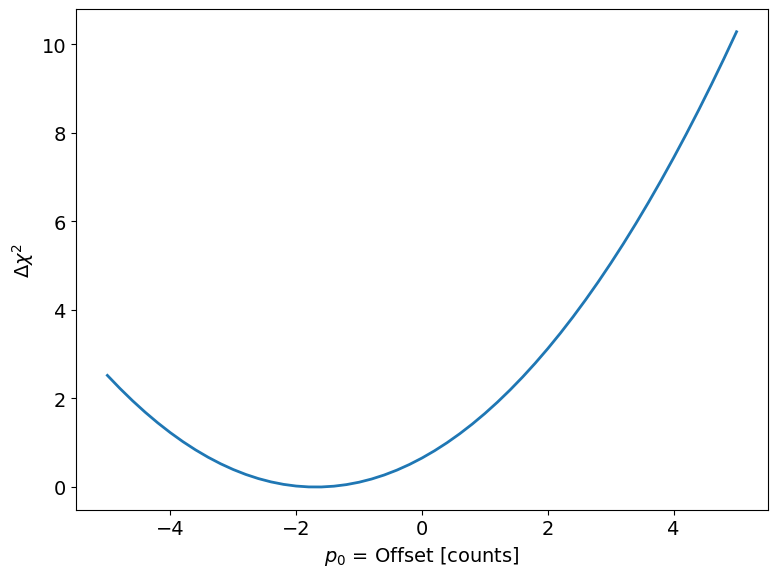

In [20]:
## Define a number of different parameter values to scan over
nscan = 51

## Start with both parameters set to zero
params = np.array([0., 0.])

## Make a list in which to store the chi^2 values for each parameter set
offset_chi2_vals = np.zeros((nscan))

## Make an array of offsets to scan over, and loop over each offset
offset_scan_points = np.linspace(-5., 5., nscan)
for i in range(nscan):
    params[0] = offset_scan_points[i]
    offset_chi2_vals[i] = chi2_function(years_since_mid_2014, excess_counts, 
                                        sigma_counts, linear_function, params)

## Subtract the minimum value from the computed chi^2 values to get
## the "delta chi^2" values. We'll assess the minimum value later, 
## since here we're concerned with how the chi^2 changes as we vary
## the offset parameter.
offset_chi2_vals -= offset_chi2_vals.min() 

## Plot the values of the offset that we scanned, and the associated chi^2 values
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(offset_scan_points, offset_chi2_vals, lw=2)

ax.set_xlabel(r"$p_0$ = Offset [counts]")
ax.set_ylabel(r"$\Delta \chi^2$")

fig.tight_layout()

plt.show()

Ok, now let's scan the slope parameter, $p_1$.  We will scan from -2 to 2 counts / year in 11 steps.

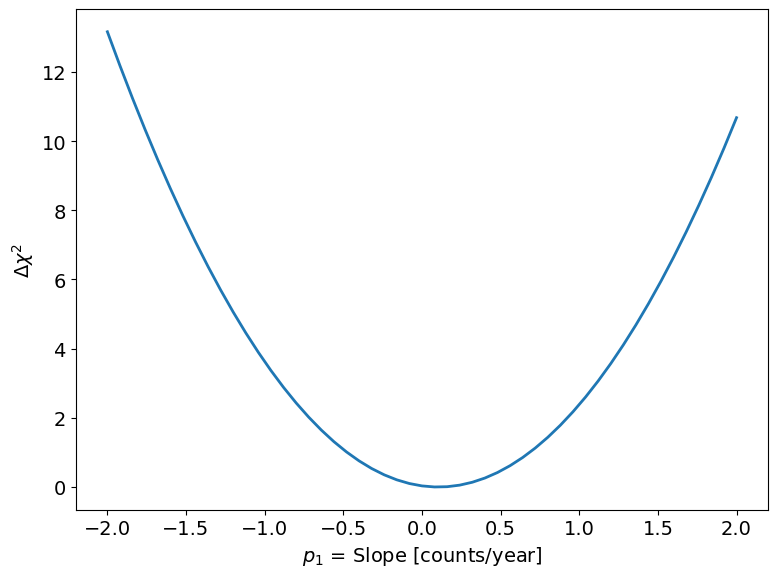

In [21]:
## Define a number of different parameter values to scan over
nscan = 51

## Start with both parameters set to zero
params = np.array([0., 0.])

## Make a list in which to store the chi^2 values for each parameter set
slope_chi2_vals = np.zeros((nscan))

## Make an array of offsets to scan over, and loop over each offset
slope_scan_points = np.linspace(-2., 2., nscan)
for i in range(nscan):
    params[1] = slope_scan_points[i]
    slope_chi2_vals[i] = chi2_function(years_since_mid_2014, excess_counts, 
                                        sigma_counts, linear_function, params)

## Subtract the minimum value from the computed chi^2 values to get
## the "delta chi^2" values. We'll assess the minimum value later, 
## since here we're concerned with how the chi^2 changes as we vary
## the offset parameter.
slope_chi2_vals -= slope_chi2_vals.min() 

## Plot the values of the offset that we scanned, and the associated chi^2 values
fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(slope_scan_points, slope_chi2_vals, lw=2)

ax.set_xlabel(r"$p_{1}$ = Slope [counts/year]")
ax.set_ylabel(r"$\Delta \chi^2$")

fig.tight_layout()

plt.show()

Now we have found $p_0,p_1$ values which minimize our $\chi^2$ metric.

As always, we are interested in the uncertainty associated with these values. Luckily, we have constructed the $\chi^2$ by summing together in quadrature a bunch of quantities that **in an ideal world**, are each distributed as a unit gaussian.  This gives us a really powerful tool to interpret changes in the $\chi^2$ value in terms of Gaussian uncertainties. 

If we are varying a **single** parameter, we can interpret changes in the parameter that result in a 1 unit change of $\chi^2$ as the $1 \sigma$ uncertainty on that parameter.  In general, if $\hat{p}$ is the set of parameter values that minimize the $\chi^2$, then we can solve for the uncertainty $\sigma_p$ using the relationship: 

$\Delta \chi^2 = \chi^2(\hat{p} + n \sigma_p) - \chi^2(\hat{p}) = n^2$

Where we can pick $n$ to be some convenient number, e.g., 1 in our case.

(With more parameters, $\pm 1\sigma_p$ uncertainties correspond to > 1 unit change of $\Delta \chi^2$, but we can ignore this for now and keep it in the back of our minds. Note that $\chi^2$ also depends on the data points, and the uncertainties on the data points, but we left that out of the equation to focus on the fact that we are just changing the model parameters and trying to match the data).

### Question for Discussion:

#### 7.1 Estimate numerical values for the best-fit values and $1\sigma$ uncertainties on $p_0$ and $p_1$ using the two plots above.

### Extracting multiple parameters at once.

Now we are going to extract best-fit values for both $p_0$ and $p_1$ by evaluting the $\chi^2$ function over points on a two dimensional grid.

We plot the result as a color plot, where the color is the $\Delta \chi^2$ value, and we are going to draw some contours on the plot correspond to different levels of $\Delta \chi^2$.

This entire process is essentially what a numerical minimizer does, but we're doing it manually to demonstrate.

In [22]:
## Alternate number of points to scan in this 2D implementation
nx = 101
ny = 101

params = np.array([0., 0.])
chi2_2d_scan_vals = np.zeros((nx, ny))

## Scan the offset between -10 and 10, and the slope between -5 and 5
offset_2d_scan_points = np.linspace(-10, 10, nx)
slope_2d_scan_points = np.linspace(-5, 5, ny)

## Double loop for 2d scan, sampling the value of chi^2 at each combination of 
## parameter values: offset and slope
for i in range(nx):
    params[0] = offset_2d_scan_points[i]
    for j in range(ny):
        params[1] = slope_2d_scan_points[j]

        chi2_2d_scan_vals[i,j] = chi2_function(years_since_mid_2014, excess_counts, sigma_counts,
                                               linear_function, params)

## Subtract the minimum chi2 value to get the "delta chi^2"
min_chi2 = chi2_2d_scan_vals.min()
chi2_2d_scan_vals -= min_chi2

## This next bit gets the x and y axis values for the grid point at the minimum.
idx = chi2_2d_scan_vals.argmin()
idx_x = idx//nx
idx_y = idx%ny

## Get the values of the offset and slope associated to the minimum chi^2
scan_min_x = offset_2d_scan_points[idx_x]
scan_min_y = slope_2d_scan_points[idx_y]

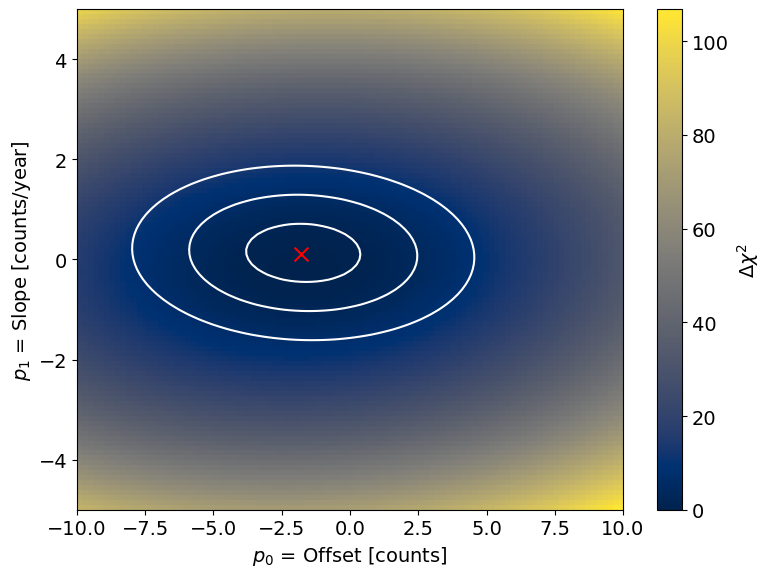

Best fit value is 764.5 for parameters (-1.80, 0.10)


In [23]:
## Now let's plot it!
fig, ax = plt.subplots(figsize=(8, 6))

## Plot the chi^2 values as a 2D image, with the color scale indicating the value of chi^2
img = ax.imshow(chi2_2d_scan_vals.T, extent=(-10, 10, -5, 5), aspect='auto', cmap='cividis')
fig.colorbar(img, label=r"$\Delta \chi^2$")

## Plot some contours associated to different values of delta chi^2, and thus
## different uncertainties on the computed parameters. We'll plot contours for
## 1, 4, and 9, which correspond to 1, 2, and 3 sigma uncertainties
ax.contour(offset_2d_scan_points, slope_2d_scan_points, chi2_2d_scan_vals.T, levels=[1, 4, 9], colors="white")

## Plot the best fit point from our manual scan
ax.scatter(scan_min_x, scan_min_y, color='red', marker='x', s=100)

ax.set_xlabel(r"$p_0$ = Offset [counts]")
ax.set_ylabel(r"$p_1$ = Slope [counts/year]")

fig.tight_layout()

plt.show()

print(f"Best fit value is {min_chi2:0.1f} for parameters ({scan_min_x:0.2f}, {scan_min_y:0.2f})")

Note that the X marking the "best fit" appears slightly offcenter from the ellipse. This is because we found this point manually by scanning a limited number of parameter values. A numerical minimizer on a computer would scan dynamically, decreasing step size and increasing resolution as it got closer and closer to the true minimum. This is essentially what the `scipy.optimize.curve_fit` function does!

There are also entire libraries/packages dedicated to this endeavor, such as [iminuit](https://scikit-hep.org/iminuit/)

# Step 6, statistical significance of fit values

By scanning in a more optimized way, we can get a smoother curve and find a "best-fit" value for the slope parameter $p_1$ given by $\hat{p}_1 = 0.13\pm0.63$

Similarly to what we did last week, we can use `scipy.stats.norm` to compute the p-value.  Once slight difference is that this time we are considering both positive and negative values, so we integrate the Gaussian outward starting from the middle, using the formula in the cell below. The hardcoded factor of 2 comes from the fact that we need to count both the positive and negative tails of the distribution, but the `.sf()` method just integrates up from a positive value.

In [24]:
def two_sided_p_chi2(x, mu, sigma):
    return 2*(stats.norm(loc=mu, scale=sigma).sf(np.abs(x)))

In [25]:
p_val = two_sided_p_chi2(0.13, 0, 0.58)
print(f"The p-value to obtain a measurement of {0.13:0.2f} given a true value of {0:0.2f} and a sigma of {0.63:0.2f} is {p_val:0.2f}")

The p-value to obtain a measurement of 0.13 given a true value of 0.00 and a sigma of 0.63 is 0.82


### Question for Discussion:

#### 8.1  Is this result statistically significant?  I.e., should we write a paper saying that Vela is getting brighter?  Why or why not?

### Quick Coding Exercise for Practice:

##### What is the p-value associated to our measured constant offset? A more precise fit yields $\hat{p}_0 = -1.7 \pm 2.3$

# Summary of this notebook

So, to investigate if the correlation was significant we did a few things:

1. A **model** with **parameters** to describe the data.  In our case we fit the excess as a function of time to a line,  i.e., $m_{\rm excess}(t | p_0, p_1) = p_0 + t * p_1$ 

2. A function to compute how close the model is to each data point.   I.e., how well the model fits the data.  To do this we will first compute the **residuals** for each data point: $\delta_i = n_{\rm ex,i} - m_{\rm ex,i} = n_{\rm ex,i} - (p_0  + t * p_1)$ 

3. To interpret the residuals we **scaled** them by their uncertainties, in this case those are the uncertainties shown in the plot above, which are just the square root of the number of observed counts, let's call these $\sigma_i = \sqrt{n_{obs, i}}$,  Then we have  $\chi_i =  \frac{n_{\rm ex,i} - m_{\rm ex,i}}{\sigma_{obs, i}} = \frac{n_{\rm ex,i} - (p_0  + t_i * p_1)}{\sigma_{obs, i}}$   At that point, if the model were perfect the scaled residuals $\chi_i$ should each be a variable sampled from a unit Gaussian, i.e., $G(\chi_i | \mu=0, \sigma=1)$.

4. The next step was to **test** how well the model fits the data.  Since we have a bunch of data points that ideally should be represented by Gaussians, we can add the variances in quadrature to get a meaningful quantity.  $\chi^2 = \sum_i \chi_i^2 = \sum_i (\frac{n_{\rm ex,i} - (p_0  + t_i * p_1)}{\sigma_{obs, i}})^2$.   The $\chi^2$ tells us how well the model fits the data, on average we expect each data point to contribute about 1 unit to the total $\chi^2$ (because each point is coming from a unit Gaussian).   Lower $\chi^2$ represent better fits.

5. We varied the input parameters $(p_0, p_1)$ to find the values that **minimize** the $\chi^2$.

6. Finally, compared the change in $\chi^2$ between the best fit model and other parameter values and use this to intepret the statistical significance.



# Bonus (optional, not for credit)

Here is a small coding exercise for you to try. 

An optimized version of what we covered in this notebook is already implemented in the `scipy.optimize.curve_fit` function. Here is an example of how to fit the model parameters and extract the values and uncertainties using this package:

In [26]:
from scipy.optimize import curve_fit

def func(x, p0, p1):
    return p0 + x*p1


popt, pcov = curve_fit(func, years_since_mid_2014, excess_counts, sigma=sigma_counts)
perr = np.sqrt(np.diag(pcov))

print("         Optimized parameters: ", popt)
print("Uncertainty on the parameters: ", perr)

         Optimized parameters:  [-1.71176548  0.12882773]
Uncertainty on the parameters:  [2.26646783 0.63044742]


#### 9.1 (Optional coding exercise)  Try fitting the data to a second order polynomial (i.e. $f(x)=p_0 + p_1*x + p_2*x^2$).  Make a plot, with labels and a legend, that shows both the fitted function and the data.

Tips: Read through the page on [scipy.optimize.curve_fit](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.curve_fit.html). The examples at the bottom are particularly helpful!

Quadratic fit parameters:
p0 = 0.44492918033970147 +/- 3.304342320227918
p1 = 0.26867932955851676 +/- 0.6495299375105595
p2 = -0.16886262763615473 +/- 0.1882426262025806


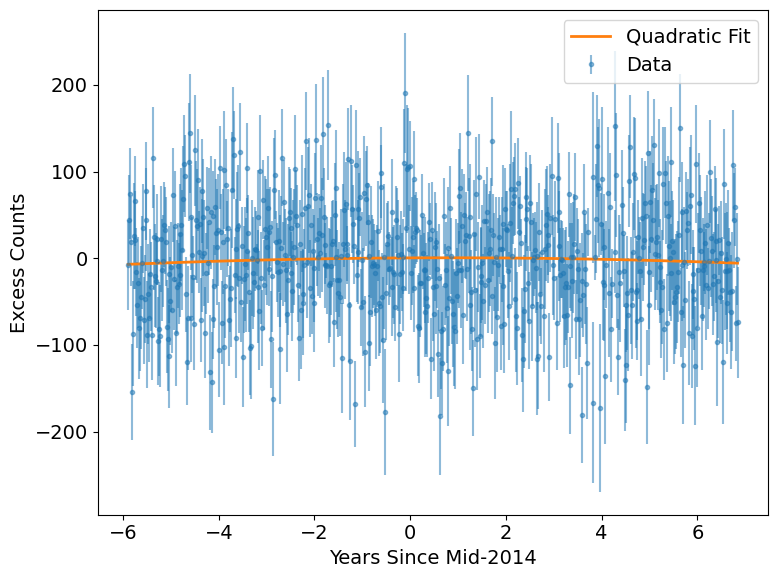

In [27]:
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt


def quad_func(x, p0, p1, p2):
    return p0 + p1*x + p2*x**2
popt_quad, pcov_quad = curve_fit(
    quad_func,
    years_since_mid_2014,
    excess_counts,
    sigma=sigma_counts
)

perr_quad = np.sqrt(np.diag(pcov_quad))

print("Quadratic fit parameters:")
print("p0 =", popt_quad[0], "+/-", perr_quad[0])
print("p1 =", popt_quad[1], "+/-", perr_quad[1])
print("p2 =", popt_quad[2], "+/-", perr_quad[2])

x_fit = np.linspace(
    years_since_mid_2014.min(),
    years_since_mid_2014.max(),
    500
)

y_fit = quad_func(x_fit, *popt_quad)


plt.figure(figsize=(8,6))


plt.errorbar(
    years_since_mid_2014,
    excess_counts,
    yerr=sigma_counts,
    fmt='o',
    markersize=3,
    alpha=0.5,
    label="Data"
)


plt.plot(
    x_fit,
    y_fit,
    linewidth=2,
    label="Quadratic Fit"
)

plt.xlabel("Years Since Mid-2014")
plt.ylabel("Excess Counts")
plt.legend()
plt.tight_layout()
plt.show()
